In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss
# remove warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from tqdm import tqdm
import time
import copy
import sklearn.metrics
from sklearn.metrics import confusion_matrix
!pip install oulumetrics
import oulumetrics

     |████████████████████████████████| 549 kB 3.9 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for oulumetrics: filename=oulumetrics-0.1-py3-none-any.whl size=2459 sha256=d2af96df8800867cc42c38019bd32356cee3616026e409e3852b944a95770b5b
  Stored in directory: /root/.cache/pip/wheels/7f/20/61/c35d3f8bc5bd6f14bf745850cfd35ef096ee31b26afc861fed
Successfully built oulumetrics


In [2]:
!pip install keras
!pip install tensorflow-addons
!pip install gdown

!gdown --id 1hnKzb1cit2dePWwfRXmNG2kxCQS-oGJy
!gdown --id 1BPI4EPPknI5FQ2t-MILqLI1bVWvf0D2U

!unzip -q Protocol1_new
!unzip -q undersampled_protocol1


/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hnKzb1cit2dePWwfRXmNG2kxCQS-oGJy
To: /kaggle/working/Protocol1_new.zip
100%|████████████████████████████████████████| 594M/594M [00:06<00:00, 85.2MB/s]
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1BPI4EPPknI5FQ2t-MILqLI1bVWvf0D2U
To: /kaggle/working/undersampled_protocol1.zip
100%|████████████████████████████████████████| 212M/212M [00:02<00:00, 87.5MB/s]


In [3]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [4]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
#             T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.20, value='random')
        ])
        train_data = datasets.ImageFolder('/kaggle/working/undersampled_protocol1/train_undersampled', transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "dev/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [5]:
dataset_path = "/kaggle/working/Protocol1_new/Protocol1_seperated/"

In [6]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, batch_size=16, train=True)
(dev_loader, test_loader, dev_data_len, test_data_len) = get_data_loaders(dataset_path,batch_size=16, train=False)

In [7]:
print(test_loader)

In [8]:
classes = get_classes("/kaggle/working/Protocol1_new/Protocol1_seperated/train/")
print(classes, len(classes))

['fake', 'true'] 2


In [9]:
dataloaders = {
    "train": train_loader,
    "val": dev_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": dev_data_len
}

In [10]:
print(len(train_loader), len(dev_loader), len(test_loader))

354 565 485


In [11]:
print(train_data_len, dev_data_len, test_data_len)

5663 9027 7758


In [12]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
# model_names = timm.list_models(pretrained=True)
# print(model_names)

In [14]:
pretrained_model_name = 'deit_base_patch16_224'   #cait_M48 cait_XXS36_224 cait_S24_224 deit_base_distilled_patch16_224 deit_base_patch16_224 deit_tiny_distilled_patch16_224
no_epochs = 1

In [15]:

learning_rate = 0.03
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    
#     nn.BatchNorm1d(192),
#     nn.Linear(n_inputs, 512),
#     nn.ReLU(),
# #     nn.BatchNorm1d(512),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(128, 64),
#     nn.ReLU(),
# #     nn.Dropout(0.2, inplace=True),
    
#     nn.Linear(64, len(classes))
    ############################################
    nn.BatchNorm1d(768),
    nn.Linear(n_inputs, 512),
    nn.Mish(),
#     nn.BatchNorm1d(512),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(512, 256),
    nn.Mish(),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(256, 128),
    nn.Mish(),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(128, 64),
    nn.Mish(),
#     nn.Dropout(0.2, inplace=True),
    
    nn.Linear(64, len(classes))
    ##############################################
    
#     nn.BatchNorm1d(192),
# #     nn.Linear(n_inputs, 512),
#     nn.PReLU(),
# #     nn.BatchNorm1d(512),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(512, 256),
#     nn.PReLU(),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(256, 128),
#     nn.PReLU(),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(128, 64),
#     nn.PReLU(),
    #################################
#     nn.Linear(n_inputs, 512),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(512, len(classes))
)

# model.head = head_params
model = model.to(device)
# print(model)
# parameters


Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [16]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.SGD(model.head.parameters(), lr=learning_rate, momentum=0.5)

In [17]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [18]:
train_accs = []
val_accs = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
#                     print(outputs)
                    _, preds = torch.max(outputs,1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                val_accs.append(epoch_acc)
            else:
                train_accs.append(epoch_acc)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [19]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=no_epochs) 


Epoch 0/0
----------


100%|██████████| 354/354 [00:45<00:00,  7.75it/s]


train Loss: 0.6105 Acc: 0.6917


100%|██████████| 565/565 [01:02<00:00,  9.03it/s]

val Loss: 0.4201 Acc: 0.8703

Training complete in 1m 48s
Best Val Acc: 0.8703


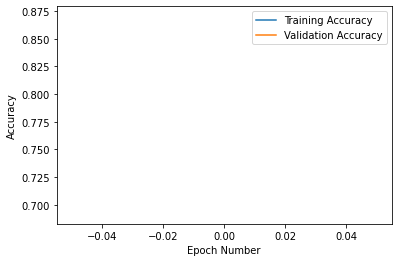

In [20]:
x = [i for i in range(no_epochs)]
# plot lines
plt.plot(x, train_accs, label = "Training Accuracy")
plt.plot(x, val_accs, label = "Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [21]:
dev_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()
dev_predictions = []
dev_targets = []

for data, target in tqdm(dev_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    dev_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    pred_list = np.squeeze(pred.cpu().numpy())
    target_list = np.squeeze(target.cpu().numpy())
    dev_predictions.extend(pred_list)
    dev_targets.extend(target_list)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
#     print('target',target)
#     print('##################################################')
#     print('output',output)
#     print('##################################################')
#     print('pred',pred)
#     print('##################################################')
#     print('correct_tensor',correct_tensor)
#     print('##################################################')
#     print('correct',correct)
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# print('class_correct',class_correct)
# print('##################################################')
# print('class_total',class_total)

dev_loss = dev_loss / dev_data_len
print('Dev Loss: {:.4f}'.format(dev_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Dev Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Dev accuracy of %5s: NA" % (classes[i]))
print("Dev Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 565/565 [01:02<00:00,  9.08it/s]


Dev Loss: 0.0001
Dev accuracy of  fake: NA
Dev accuracy of  true: NA


ValueError: cannot convert float NaN to integer

In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()
test_predictions = []
test_targets = []

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    pred_list = np.squeeze(pred.cpu().numpy())
    target_list = np.squeeze(target.cpu().numpy())
    test_predictions.extend(pred_list)
    test_targets.extend(target_list)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
#     print('target',target)
#     print('##################################################')
#     print('output',output)
#     print('##################################################')
#     print('pred',pred)
#     print('##################################################')
#     print('correct_tensor',correct_tensor)
#     print('##################################################')
#     print('correct',correct)
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# print('class_correct',class_correct)
# print('##################################################')
# print('class_total',class_total)

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))



In [ ]:
# print('Target Labels: ',len(targets))
# print('Prediction Labels: ',len(predictions))

In [ ]:
#EER
def compute_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred, positive_label)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
   
    return eer

test_EER = compute_eer(test_targets,test_predictions)
dev_EER = compute_eer(dev_targets,dev_predictions)

print('The EER for Dev is: {:.2f}'.format(dev_EER))
print('The EER for Test is: {:.2f}'.format(test_EER))

In [ ]:
#HTER
def calculate_HTER(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    far = fp / (fp + tn)
    frr = fn / (tp + fn)
    hter = (far + frr) / 2
    return hter


dev_hter = calculate_HTER(dev_targets, dev_predictions)
print('The HTER for Dev is: {:.2f}'.format(dev_hter))

test_hter = calculate_HTER(test_targets, test_predictions)
print('The HTER for Test is: {:.2f}'.format(test_hter))



In [ ]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("protocol1_model.pt")

In [ ]:
#APCER, BPCER, ACER
test_attack_types = [ (1 if x==1 else 2) for x in test_targets]
dev_attack_types = [ (1 if x==1 else 2) for x in dev_targets]


# returns the metrics APCER, BPCER and ACER
test_apcer, test_bpcer, test_acer = oulumetrics.calculate_metrics(test_attack_types, test_predictions)
dev_apcer, dev_bpcer, dev_acer = oulumetrics.calculate_metrics(dev_attack_types, dev_predictions)

print('######## Dev Oulu Metrics ##########')
print('APCER: {:.2f}'.format(dev_apcer))
print('BPCER: {:.2f}'.format(dev_bpcer))
print('ACER: {:.2f}'.format(dev_acer))

print('######## Test Oulu Metrics ##########')
print('APCER: {:.2f}'.format(test_apcer))
print('BPCER: {:.2f}'.format(test_bpcer))
print('ACER: {:.2f}'.format(test_acer))





In [ ]:
!pip install pillow
from PIL import Image


In [ ]:

# transform = T.Compose([
#             T.RandomHorizontalFlip(),
#             T.RandomVerticalFlip(),
# #             T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
#             T.Resize(256),
#             T.CenterCrop(224),
#             T.ToTensor(),
#             T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
#             T.RandomErasing(p=0.20, value='random')
#         ])

# img = Image.open("/kaggle/working/undersampled_protocol1/train_undersampled/true/1_1_01_1_001_rgb.jpg")
# img_tensor = transform(img).unsqueeze(0)  # add a batch dimension

# with torch.no_grad():
#     features = model.forward_features(img_tensor).squeeze()  # remove the batch dimension

# print(features.shape)
# print(features)

In [22]:
model = model_ft.to(device)

In [ ]:
features = []
labels_array = []

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        # Pass the images through the DeiT model to obtain the features
        outputs = model.forward_features(images)
        # Reshape the output tensor to (batch_size, num_features)
        features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
        labels_array.append(labels.numpy())

# Concatenate the features into a single numpy array
features = np.concatenate(features, axis=0)
# Concatenate the labels into a single numpy array
labels_array = np.concatenate(labels_array).flatten()
x_train = pd.DataFrame(features)
y_train = pd.DataFrame(labels_array)
x_train.to_csv('x_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
print(x_train.shape,y_train.shape)

100%|██████████| 354/354 [00:42<00:00,  8.41it/s]


In [ ]:
features = []
labels_array = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        # Pass the images through the DeiT model to obtain the features
        outputs = model.forward_features(images)
        # Reshape the output tensor to (batch_size, num_features)
        features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
        labels_array.append(labels.numpy())

# Concatenate the features into a single numpy array
features = np.concatenate(features, axis=0)
# Concatenate the labels into a single numpy array
labels_array = np.concatenate(labels_array).flatten()
x_test = pd.DataFrame(features)
y_test = pd.DataFrame(labels_array)
print(x_test.shape,y_test.shape)

In [ ]:
features = []
labels_array = []
with torch.no_grad():
    for images, labels in tqdm(dev_loader):
        images = images.to(device)
        # Pass the images through the DeiT model to obtain the features
        outputs = model.forward_features(images)
        # Reshape the output tensor to (batch_size, num_features)
        features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
        labels_array.append(labels.numpy())

# Concatenate the features into a single numpy array
features = np.concatenate(features, axis=0)
# Concatenate the labels into a single numpy array
labels_array = np.concatenate(labels_array).flatten()
x_dev = pd.DataFrame(features)
y_dev = pd.DataFrame(labels_array)
print(x_dev.shape,y_dev.shape)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Create an XGBRegressor model
model = xgb.XGBRegressor()

# Define the hyperparameters to search over
param_grid = {
     'n_estimators': [100, 500, 1000],
     "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
}

# Create a grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the development data
grid_search.fit(X_dev, y_dev)

# Print the best hyperparameters and the corresponding mean test score
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Best mean test score: {grid_search.best_score_}')

# Train the model with the best hyperparameters on the combined train/dev set
best_model = xgb.XGBRegressor(**grid_search.best_params_)
best_model.fit(x_train, y_train)

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)
print(f'Test score: {test_score}')



In [ ]:
y_pred = best_model.predict(x_test)
y_actual = y_test

In [ ]:
accuracy = accuracy_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)
cm = confusion_matrix(y_actual, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")
print("Confusion matrix:")
print(cm)





